In [1]:
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import pprint

import evo.core.transformations as tr

from copy import deepcopy
from evo.core import metrics, sync
from evo.core import lie_algebra as lie
from evo.core.trajectory import PosePath3D
from evo.tools import plot, file_interface

from scipy.spatial.transform import Rotation as R

from rosbags.rosbag2.writer import Writer as BagWriter
from rosbags.rosbag2.reader import Reader as BagReader

from tools.tum_tools import *
from tools.tum_plots import *
from tools.tum_definitions import *

%load_ext autoreload
%autoreload 2

%matplotlib inline
%matplotlib widget


In [ ]:
!evo_traj tum ekf_pose_with_covariance.tum --ref in_pose_with_covariance.tum -p

# Initial Evaluation

In [ ]:
# Load previously computed data
route = "mdv3_1"
data_root = f"data/pickle/{route}"

# gt_file = os.path.join(data_root, "full", "gt_poses.pkl")
gt_file = os.path.join("data", "reference", f"{route}_reference.tum")
traj_file = os.path.join(data_root, "full2", "kiss_trajectories_corrected_corr.pkl")
# traj_file = os.path.join(data_root, "full2", "kiss_trajectories.pkl")

# gt_dict = read_pickle(gt_file)
traj_dict = read_pickle(traj_file)

In [ ]:
# Extract relevant data
current_key = "mdv3_full_merge"
# traj_ref = gt_dict['trajectory']
traj_ref = file_interface.read_tum_trajectory_file(gt_file)
traj_est = traj_dict[current_key][2]
traj = (traj_ref, traj_est)


In [ ]:
plot_compare(traj, print_stats=False, plot_mode='rpy')

In [ ]:
plt.savefig(f"figures/ape_{current_key}.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# PLOT THE FULL SET
max_diff = 0.01
results = {}

for recording in Mdv3Dataset:
    if traj_dict.get(recording.value) is None:
        print(f"Info: Did not found a recorded trajectory for {recording.value}")
        continue
    else:
        print(f"Processing: {recording.value}")

    traj_ref = gt_dict['trajectory']
    traj_est = traj_dict[recording.value][2]
    ape_stats = plot_compare((traj_ref, traj_est), plot_mode='ape', max_diff=max_diff)
    
    plt.savefig(f"tmp/ape_{recording.value}.pdf", format="pdf", bbox_inches="tight")
    results[recording.value] = ape_stats
    

In [ ]:
for recording, stats in results.items():
    print(f"Statistics for {recording}")
    pprint.pprint(stats)

In [ ]:
results

In [ ]:
import csv

fields = [ 'Type', 'max', 'mean', 'median', 'min', 'rmse', 'sse', 'std']


with open("test_output.csv", "w") as f:
    w = csv.DictWriter(f, fields)
    w.writeheader()
    for k in results:
        w.writerow({field: results[k].get(field) or k for field in fields})

In [ ]:
plot_trajectories_from_poses(traj_ref, traj_est)

# Analysis of KISS-ICP For Chapter 5

In [2]:
# Setup
route = "mdv3_1"
data_key = "mdv3_full_merge"

data_root = f"data/pickle/{route}"
uncorrected_traj_file = os.path.join(data_root, "kiss_trajectories.pkl")
# preprocessed_traj_file = os.path.join(data_root, "kiss_trajectories_preprocessed.pkl")

# reference_file = f"data/reference/{route}_reference.tum"

In [3]:
# Reading of saved poses
uncorrected_traj = read_pickle(uncorrected_traj_file)[data_key][2]
# preprocessed_traj = read_pickle(preprocessed_traj_file)[data_key][2]
# reference_traj = file_interface.read_tum_trajectory_file(reference_file)

data_path = "/home/julian/projects/thesis/datasets/df_analysis"
bag_path = os.path.join(data_path, route, "02_with_kiss", "run_01")
bag_reader = BagReader(bag_path)
bag_reader.open()
traj_gt_gps = file_interface.read_bag_trajectory(bag_reader, "/ekf/gt/gps")

traj_ref = traj_gt_gps
# traj_ref = reference_traj
traj_est_original = uncorrected_traj

## Enable for analyzing the preprocessed PC's (currently only available for Route 2 ...)
# traj_est_original = preprocessed_traj

In [4]:
# Trajectory Alignment

# Extract the angles from the reference
yaw_rad = (next((rot[2] for rot in traj_ref.get_orientations_euler() if math.fabs(rot[2]) > 1e-15)))
rpy_rad = np.asarray([traj_ref.get_orientations_euler()[0][0], traj_ref.get_orientations_euler()[0][1], yaw_rad])

# Align Roll, Pitch, and Yaw
traj_est_aligned_rpy = deepcopy(traj_est_original)
origin_se3 = np.eye(4)
origin_se3[:3,:3] = R.from_euler("xyz", rpy_rad).as_matrix()
_ = traj_est_aligned_rpy.align_origin(PosePath3D(poses_se3=[origin_se3]))

# Only align Yaw
traj_est_aligned_y = tum_tools.align_origin(deepcopy(traj_est_original), yaw_deg= 281 if route=="mdv3_2" else 101)

# Align using Umeyama method
traj_est_umeyama = deepcopy(traj_est_original)
traj_ref_umeyama, traj_est_umeyama = tum_tools.sync_trajectories(traj_ref, traj_est_umeyama, 0.1)
umeyama_transform = traj_est_umeyama.align(deepcopy(traj_ref_umeyama))
# rot = R.from_matrix(umeyama_re[0]).as_quat()
# correction = PosePath3D(orientations_quat_wxyz=[rot], positions_xyz=[[0,0,0]])
# _ = traj_est_umeyama.align_origin(correction)


In [ ]:
# Print info about the extracted angles
ref_tmp = deepcopy(traj_ref)
est_tmp = deepcopy(traj_est_aligned)

ref_tmp, est_tmp = tum_tools.sync_trajectories(ref_tmp, est_tmp, 0.1)

est_angles_rad = np.asarray(est_tmp.get_orientations_euler())
ref_angels_rad = np.asarray(ref_tmp.get_orientations_euler())

assert len(est_angles_rad) == len(ref_angels_rad)

diffs = np.abs(est_angles_rad - ref_angels_rad)

print(diffs.shape)


print(f"Max Roll Diff: {np.max(diffs[:,0])*180/math.pi}\nMax Ptich Diff: {np.max(diffs[:,1])*180/math.pi}")
print(f"Max Roll Diff: {np.argmax(diffs[:,0])}\nMax Ptich Diff: {np.argmax(diffs[:,1])}")


In [5]:

p = lie.se3(umeyama_transform[0], umeyama_transform[1])
traj_est_umeyama_transformed = deepcopy(traj_est_original)
traj_est_umeyama_transformed.transform(p)

file_interface.write_tum_trajectory_file("kiss_poses_umeyama.tum", traj_est_umeyama_transformed)

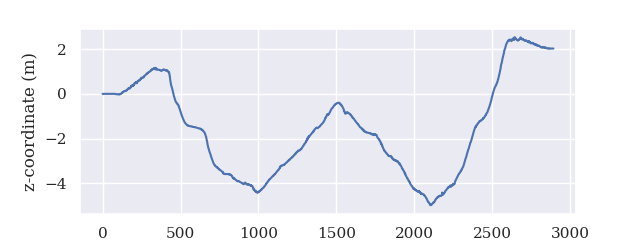

In [65]:

t1 = read_pickle("data/pickle/mdv3_1/kiss_trajectories.pkl")[data_key][2]
t2 = read_pickle("data/pickle/mdv3_2/kiss_trajectories.pkl")[data_key][2]

plt.close('all')
# fig = plt.figure(figsize=get_figsize(wf=2.5,hf=.2))
fig = plt.figure(figsize=[6.4, 2.4])
# # ax = fig.add_subplot(211)
# # ax.set_xlabel("Index")
# ax.set_ylabel("z-coordinate (m)")
# # ax.set_title("Route 1")
# ax.plot(t1.positions_xyz[:,2])
# ax = fig.add_subplot(212)
# # ax.set_title("Route 2")
# ax.set_ylabel("z-coordinate (m)")
# # ax.set_xlabel("Index")
# ax.plot(t2.positions_xyz[:,2])

plt.plot(t1.positions_xyz[:,2])
plt.xlabel("Index")
plt.ylabel("z-coordinate (m)")

plt.savefig
# plt.xlabel("Index")
plt.savefig("/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/03_kiss_ekf-analysis/mdv3_1_kiss-z-only.pdf", format="pdf", bbox_inches="tight")

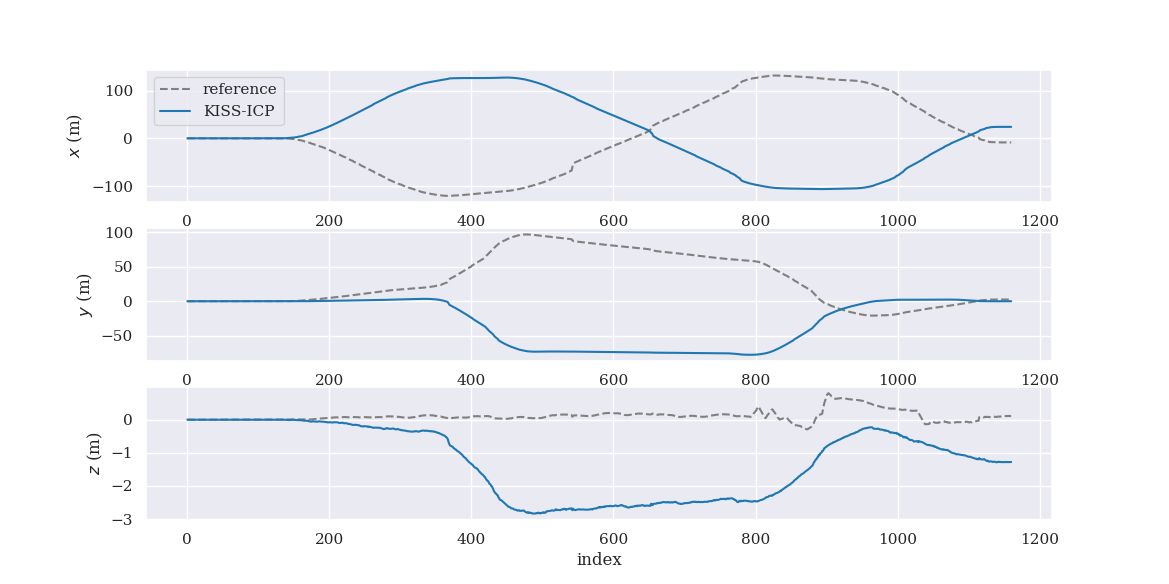

In [17]:
plot_compare((traj_ref, traj_est_original), align_origin=False,
             print_stats=True, plot_mode='xyz', max_diff=0.1,
            est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)

In [ ]:
plot_compare((traj_ref, traj_est_umeyama_transformed), align_origin=False,
             print_stats=True, plot_mode='xyz', max_diff=0.1,
            est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)

In [ ]:
plot_compare((traj_ref, traj_est_umeyama), align_origin=False,
             print_stats=True, plot_mode='xyz', max_diff=0.1,
            est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)

In [ ]:
plot_compare((traj_ref, traj_est_umeyama), align_origin=False,
             print_stats=True, plot_mode='xyz', max_diff=0.1,
            est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)

In [ ]:
# Plot after Umeyama alignment

# Ref is the "old" version
plot_compare((traj_ref, traj_est_umeyama), align_origin=False,
             print_stats=True, plot_mode='xyz', max_diff=0.1,
            est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)
# plt.savefig(f"figures/eval/kiss_align/{route}_rpy_plot_umeyama.pdf", format="pdf", bbox_inches="tight")

# plot_trajectory_segments(traj_ref_umeyama, n = 100)

In [ ]:
ape_metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
ape_metric.process_data((traj_ref_umeyama, traj_est_umeyama))
plot_statistical_error_metric(ape_metric, show_plot=False, save_dir="", name_prefix="")

In [ ]:
# Plot after alignment of RPY

plot_compare((traj_ref, traj_est_aligned_rpy), align_origin=False,
             print_stats=True, plot_mode='ape', max_diff=0.1, 
             est_name="KISS-ICP", pose_relation=metrics.PoseRelation.full_transformation)
#plt.savefig(f"figures/eval/kiss_align/{route}_rpy_plot.pdf", format="pdf", bbox_inches="tight")
# plot_trajectories_from_poses(reference_traj, [uncorrected_traj, traj_est_aligned, traj_est_aligned_2], ["Uncorrected", "Aligned RPY", "Aligned Y"])

In [ ]:
out_path = f"/home/julian/projects/thesis/datasets/{route}_kiss/"

writer = BagWriter(out_path)
writer.open()
file_interface.write_bag_trajectory(writer, traj_est_umeyama, "/kiss/odometry", "base_link")
writer.close()

In [ ]:
plot_compare((traj_ref, traj_est_aligned_y), print_stats=True, plot_mode='ape', max_diff=0.01, pose_relation=metrics.PoseRelation.rotation_part)